<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/clickbait_mm_transfer_learning_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

#Imports

In [148]:
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
#print("Tensorflow version " + tf.__version__)

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

import keras
from keras import layers, regularizers, optimizers
from keras.layers import Dense, Add, Flatten, Input, Activation, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Lambda, concatenate
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


#Configurations

In [134]:
PATH_OUTPUT = '/content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/'
TARGET_SIZE = [180, 180]
CLASSES = [b'nonclickbaits', b'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180

In [135]:
# splitting data files between training, validation and test
filenames = tf.io.gfile.glob(PATH_OUTPUT + "*.tfrec")
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
intermediate_filenames = filenames[:split]
test_split = int(len(intermediate_filenames) * TESTING_SPLIT)
validation_filenames = intermediate_filenames[test_split:]
testing_filenames = intermediate_filenames[:test_split]

print("Pattern matches {} data files. Splitting dataset into {} training files , {} validation files and {} test files".format(len(filenames), len(training_filenames), len(validation_filenames), len(testing_filenames)))
validation_steps = int(15572 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15572 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 12 training files , 2 validation files and 2 test files
With a batch size of 32, there will be 364 batches per training epoch and 60 batch(es) per validation run.


In [230]:
#@title "Utilities - RUN ME"

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, ((image,text), label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(CLASSES[label.numpy()], fontsize=16)
    subplot += 1
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

          

def display_one_image(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_image(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64)  # two integers
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    return image, text, class_num, label, height, width

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  dataset = dataset.map(lambda image, text, class_num, label, height, width: ((image,text), class_num))
  return dataset

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.shuffle(10000)
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def create_image_model():
  base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(WIDTH, HEIGHT, 3),
    include_top=False,
  )  
  # Freeze the base_model
  base_model.trainable = False
  # Create new model on top
  inputs = keras.Input(shape=(WIDTH, HEIGHT, 3))

  norm_layer = keras.layers.experimental.preprocessing.Normalization()
  mean = np.array([127.5] * 3)
  var = mean ** 2
  # Scale inputs to [-1, +1]
  x = norm_layer(inputs)
  norm_layer.set_weights([mean, var])

  x = base_model(x, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
  x = keras.layers.Dense(512, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Lambda(lambda xz:K.l2_normalize(xz,axis=1))(x)
  model = keras.Model(inputs, outputs)
  return model 

def create_text_model():
  text_model = tf.keras.models.Sequential()
  text_model.add(hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                        input_shape=[], 
                        dtype=tf.string, 
                         trainable=True))
  text_model.add(Dropout(0.15))
  text_model.add(tf.keras.layers.Dense(512, activation='relu'))
  text_model.add(Dropout(0.15))
  text_model.add(Lambda(lambda xz:K.l2_normalize(xz,axis=1)))
  return text_model 

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non clickbaits Detected (True Negatives): ', cm[0][0])
  print('Non-Clickbaits Detected as Clickbaits (False Positives): ', cm[0][1])
  print('Clickbaits Detected as Non-clickbaits (False Negatives): ', cm[1][0])
  print('Clickbaits Detected (True Positives): ', cm[1][1])
  print('Total Non-clickbaits: ', np.sum(cm[0]))
  print('Total Clickbaits: ', np.sum(cm[1]))
  
def get_metrics(testy, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(testy, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(testy, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(testy, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testy, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(testy, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(testy, y_pred)
    print(matrix)

def predict_on_test(model, ds, N=1):
  test_data = ds.take(N)
  test_image=[]
  test_text=[]
  y_true=[]
  
  for (images,texts), labels in test_data:
    for i in range(BATCH_SIZE):
      test_image.append(images[i].numpy())
      test_text.append(texts[i].numpy())
      y_true.append(labels[i].numpy())



  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  print()
  plot_cm(y_true, predicted_scores)
  return test_image, test_text, y_true, y_pred

#Load data

In [137]:
# instantiate the datasets
train_ds = get_batched_dataset(training_filenames, train=True)
val_ds = get_batched_dataset(validation_filenames, train=False)
test_ds = get_batched_dataset(testing_filenames, train=False)

In [138]:
#@title "Speed test"
for (image, text), class_num in train_ds.take(1):
  for i in range(32):
    print(f"Image shape {image[i].shape}, Text {text[i]}, Class={class_num[i]}, Label={CLASSES[class_num[i]]}")

Image shape (180, 180, 3), Text b'believe it or not flying is safer than ever with transasia flight crashing in taiwan this week after a year of several horrifying accidents it may seem like plane crashes are becoming more frequent but thankfully that s not what the statistics show subscribe to our channel vox com is news website that helps you cut through the noise and understand what s really driving the events in the headlines check out to get up to speed on everything from kurdistan to the kim kardashian app check out our full video catalog follow vox on twitter or on facebook', Class=0, Label=b'nonclickbaits'
Image shape (180, 180, 3), Text b'goodbye london my social media links my instagram mo vlogs my sisters instagram lanarose my snapchat mohamedoo my sisters snapchat lana rose facebook twitter my sister s youtube channel', Class=1, Label=b'clickbaits'
Image shape (180, 180, 3), Text b'st time going to the doctor in years st time going to the doctor in years leave a like if you

#Build and compile model

##Image model

In [139]:
img_model = create_image_model()
img_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
normalization_5 (Normalizati (None, 180, 180, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0  

##Text model

In [140]:
txt_model = create_text_model()
txt_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
lambda_11 (Lambda)           (None, 512)               0         
Total params: 257,060,480
Trainable params: 257,060,480
Non-trainable params: 0
_________________________________________________________________


##Text-Image combined multi-modal model

In [141]:
merged=concatenate([img_model.output,txt_model.output])
out=Dense(512, activation='relu')(merged)
out =Dense(256, activation='relu')(out)
out =Dense(128, activation='relu')(out)
out =Dense(1, activation='sigmoid')(out)
final_model=Model([img_model.input,txt_model.input],out) 
final_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 180, 180, 3)  7           input_12[0][0]                   
__________________________________________________________________________________________________
xception (Functional)           (None, 6, 6, 2048)   20861480    normalization_5[0][0]            
__________________________________________________________________________________________________
keras_layer_5_input (InputLayer [(None,)]            0                                            
___________________________________________________________________________________________

In [142]:
LOSS = keras.losses.BinaryCrossentropy(from_logits=True)
OPTIMIZER = tf.keras.optimizers.RMSprop(lr=1.6192e-5)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
 ]

In [143]:
final_model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
    )

#Model Training

In [144]:
#callbacks
es = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
    )

In [145]:
EPOCHS=50

history = final_model.fit(
  train_ds,
  steps_per_epoch = steps_per_epoch,
  validation_data=val_ds,
  validation_steps=validation_steps,
  epochs=EPOCHS,
  verbose=1,
  callbacks=[es]
)

Epoch 1/50


364/364 [==============================] - 74s 160ms/step - loss: 0.6395 - tp: 2533.0137 - fp: 964.1562 - tn: 2184.7507 - fn: 173.9918 - accuracy: 0.7441 - precision: 0.6754 - recall: 0.9480 - auc: 0.8827 - prc: 0.8716 - val_loss: 0.2940 - val_tp: 786.0000 - val_fp: 52.0000 - val_tn: 1001.0000 - val_fn: 81.0000 - val_accuracy: 0.9307 - val_precision: 0.9379 - val_recall: 0.9066 - val_auc: 0.9717 - val_prc: 0.9735
Epoch 2/50
364/364 [==============================] - 56s 154ms/step - loss: 0.2545 - tp: 2473.7178 - fp: 136.2384 - tn: 3004.1096 - fn: 241.8466 - accuracy: 0.9337 - precision: 0.9463 - recall: 0.9083 - auc: 0.9722 - prc: 0.9747 - val_loss: 0.1478 - val_tp: 800.0000 - val_fp: 33.0000 - val_tn: 1020.0000 - val_fn: 67.0000 - val_accuracy: 0.9479 - val_precision: 0.9604 - val_recall: 0.9227 - val_auc: 0.9863 - val_prc: 0.9862
Epoch 3/50
364/364 [==============================] - 57s 156ms/step - loss: 0.1293 - tp: 2534.0658 - fp: 88.9945 - tn: 3050.3616 - fn: 182.4904 - accuracy

In [146]:
final_model.save('/content/drive/MyDrive/Colab Notebooks/Clickbait detection/model_path/simple_mm_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Clickbait detection/model_path/simple_mm_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Clickbait detection/model_path/simple_mm_model/assets


#Plot training history

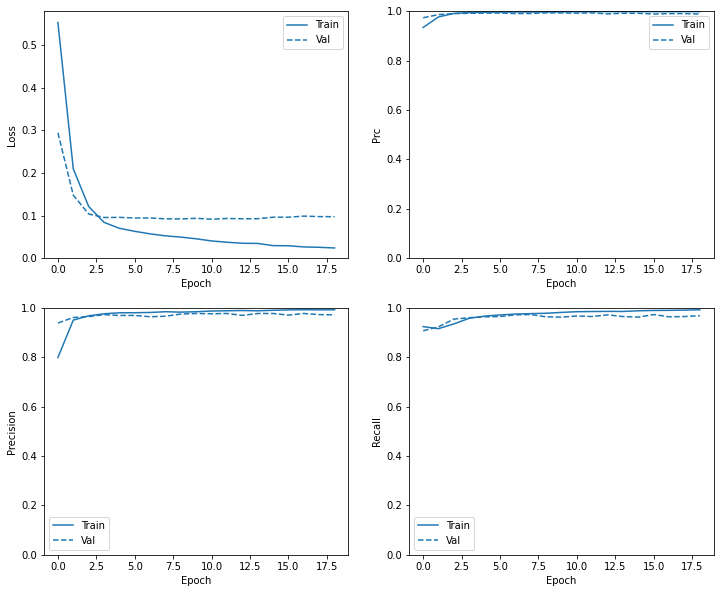

In [152]:
plot_metrics(history)

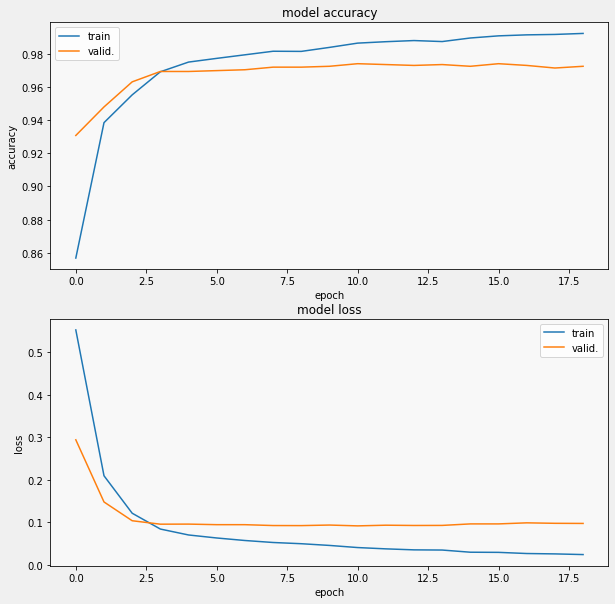

In [154]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

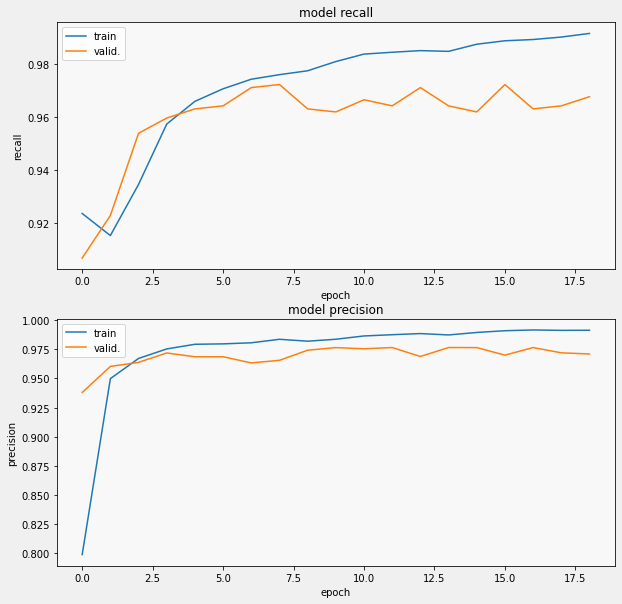

In [155]:
display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Predictions

In [217]:
saved_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Clickbait detection/model_path/simple_mm_model')

In [218]:
results = saved_model.evaluate(test_ds)

for name, value in zip(saved_model.metrics_names, results):
  print(name, ': ', value)
print()
  

61/61 [==============================] - 7s 92ms/step - loss: 0.0846 - tp: 858.0000 - fp: 18.0000 - tn: 1034.0000 - fn: 38.0000 - accuracy: 0.9713 - precision: 0.9795 - recall: 0.9576 - auc: 0.9950 - prc: 0.9940
loss :  0.08459142595529556
tp :  858.0
fp :  18.0
tn :  1034.0
fn :  38.0
accuracy :  0.9712525606155396
precision :  0.9794520735740662
recall :  0.9575892686843872
auc :  0.9950110912322998
prc :  0.9939837455749512



Accuracy: 0.977083
Precision: 0.981308
Recall: 0.967742
F1 score: 0.974478
ROC AUC: 0.976266
[[259   4]
 [  7 210]]

Non clickbaits Detected (True Negatives):  259
Non-Clickbaits Detected as Clickbaits (False Positives):  4
Clickbaits Detected as Non-clickbaits (False Negatives):  7
Clickbaits Detected (True Positives):  210
Total Non-clickbaits:  263
Total Clickbaits:  217


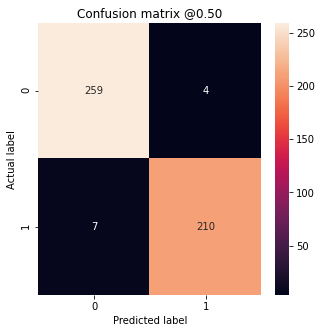

In [231]:
test_image, test_text, y_true, y_pred = predict_on_test(saved_model,test_ds,N=15)

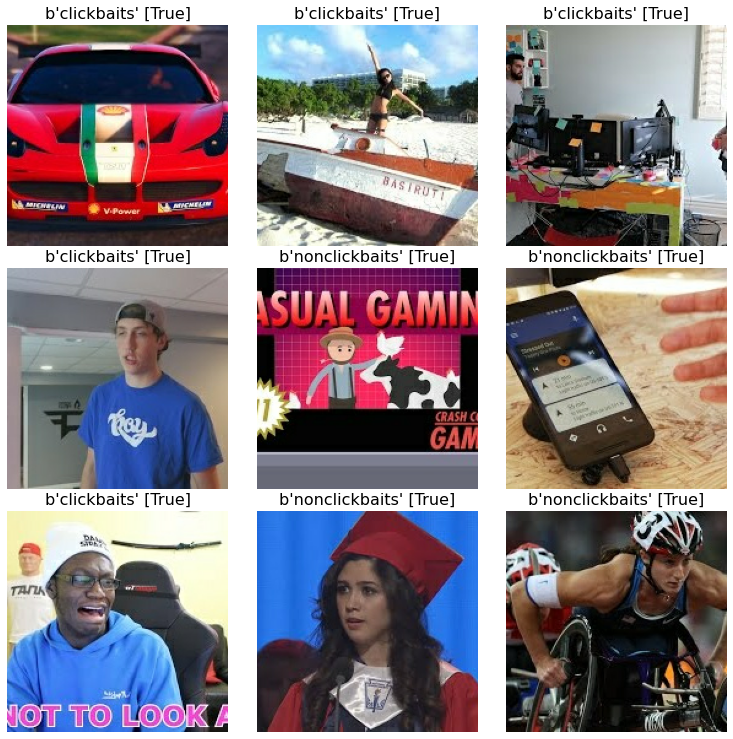

In [239]:
display_9_images_with_predictions(test_image[100:], y_pred[100:], y_true[100:])